In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import re
import wordcloud
import plotly.graph_objects as go
import plotly.express as px

In [2]:
data = pd.read_csv('../data/combined_clean_v10_nonsource.csv', sep = "|")
data['clean'] = data['clean'].values.astype('U')

In [3]:
print(data.shape)

data = data.drop_duplicates().reset_index(drop = True)
print(data.shape)



(241413, 4)
(240322, 4)


In [4]:
data.sample(n = 20)

source  year  \
46076     ABC Australia  2019   
73575     ABC Australia  2017   
162131         atlantic  2018   
221047         Fox News  2020   
124038         guardian  2020   
168022         atlantic  2018   
41513     ABC Australia  2016   
36691   Huffington Post  2017   
104914              npr  2020   
174191         atlantic  2017   
225645         Fox News  2017   
180142         atlantic  2016   
217543         Fox News  2016   
223096         Fox News  2019   
214689         Fox News  2017   
233703         Fox News  2020   
130804         guardian  2019   
11007   Huffington Post  2017   
112660              npr  2020   
61126     ABC Australia  2017   

                                                    clean  is_sarcastic  
46076   sri lanka arrests dozens after man killed mob ...             0  
73575   bowlers beyonce social media campaign prompts ...             0  
162131        wisconsin has never seen anything like this             0  
221047  pence addresses fly on his head at vice presid...             0  
124038  american dirts problem is bad writing not cult...             0  
168022  donald trump doesnt understand whats happening...             0  
41513       west papuans await decision on msg membership             0  
36691   anderson cooper questions whether trump is pre...             0  
104914  walmart faces lawsuit over worker death from c...             0  
174191     isis will fail but what about the idea of isis             0  
225645                    hasan letter and army statement             0  
180142         the evacuation of washington union station             0  
217543  president pushes obamacare despite doubledigit...             0  
223096  harry styles discusses questions about his sex...             0  
214689  fbi raids former trump campaign chair home sei...             0  
233703     the moon is rusting and scientists are stunned             0  
130804  dday anniversary macron and trump to meet agai...             0  
11007   selfproclaimed inventor of email is back with ...             0  
112660  i like what i see faa chief flies 737 max but ...             0  
61126             grandstand at stumps third test day one             0

In [5]:
data.describe()

year   is_sarcastic
count  240322.000000  240322.000000
mean     2017.922516       0.091648
std         1.392207       0.288529
min      2016.000000       0.000000
25%      2017.000000       0.000000
50%      2018.000000       0.000000
75%      2019.000000       0.000000
max      2020.000000       1.000000

In [6]:
sarcastic_year_group = data.groupby(['year','is_sarcastic']).count()
sarcastic_year_group = sarcastic_year_group.reset_index()
sarcastic_year_group = sarcastic_year_group[[ 'year', 'is_sarcastic', 'clean']]
sarcastic_year_group.columns = ['year', 'is_sarcastic', 'count']

In [7]:
fig = px.bar(sarcastic_year_group, x="year", y="count", color="is_sarcastic", title="Satirical vs Non-Satirical")
fig.show()

In [8]:
source_year_group = data.groupby(['source','year','is_sarcastic']).count()
source_year_group = source_year_group.reset_index()
source_year_group = source_year_group[['source', 'year', 'is_sarcastic', 'clean']]
source_year_group.columns = ['source', 'year', 'is_sarcastic', 'count']

In [9]:
fig = px.bar(source_year_group, x="year", y="count", color="source", title="Sources by Year")
fig.show()

In [10]:
fig = px.bar(source_year_group, x="source", y="count", color="year", title="Year by Source")
fig.show()

### Word Frequency

In [11]:
all_text = " ".join(data['clean'].values)
splitted = all_text.split()
word_counts = {}
for word in splitted:
    word_counts[word] = word_counts.get(word, 0) + 1

In [12]:
word_dicts_list = []

for word in word_counts.keys():
    word_dicts_list.append({"word": word, "count": word_counts[word]})

In [14]:
wc_df = pd.DataFrame(word_dicts_list)
wc_df = wc_df.sort_values('count', ascending = False).reset_index(drop = True)
wc_df['cumsum'] = wc_df['count'].cumsum()

In [15]:
wc_df.loc[wc_df['count'] == 10]

word  count   cumsum
14825  legislator     10  2234759
14826    routines     10  2234769
14827       diddy     10  2234779
14828       toads     10  2234789
14829    solitude     10  2234799
...           ...    ...      ...
15716   londoners     10  2243669
15717  culturally     10  2243679
15718        vase     10  2243689
15719  miniseries     10  2243699
15720     phrases     10  2243709

[896 rows x 3 columns]

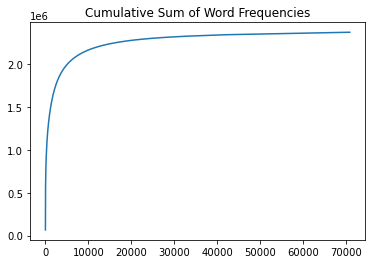

In [16]:
plt.plot(np.cumsum(a = wc_df['count']))
plt.title("Cumulative Sum of Word Frequencies")
plt.show()

In [18]:
idx = 15720

print(np.cumsum(a = wc_df['count'])[idx]/np.sum(wc_df['count']))
wc_df.iloc[idx]

0.9463433048282843


word      phrases
count          10
cumsum    2243709
Name: 15720, dtype: object

### Source Specific Language

In [19]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [20]:
data['token_len'] = data['clean'].apply(lambda x: len(str(x).split()))
data = data.loc[data['token_len'] > 0]
data = data.loc[data['token_len'] <= 41]
data.reset_index(inplace = True, drop = True)

In [23]:
cv = feature_extraction.text.CountVectorizer(lowercase = True,
                                             strip_accents = 'ascii',
                                             ngram_range=(1,3),
                                             stop_words="english",
                                             max_df = .8,
                                             min_df = 10, binary = True)

In [24]:
train = data.loc[data['year'] != 2020]
test = data.loc[data['year'] == 2020]

X_train = train['clean'].values.astype('U')

In [25]:
print("Fitting Count Vectorizer")
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

Fitting Count Vectorizer


In [26]:
train['source'].unique()

array(['Huffington Post', 'ABC Australia', 'npr', 'guardian',
       'nottheonion', 'atlantic', 'onion', 'reductress',
       'national report', 'Hard Times', 'Fox News'], dtype=object)

In [27]:
source_specific = []
for source in train['source'].unique():
    Y_train = train['source'].apply(lambda x: 1 if x == source else 0)
    lr_cv = LogisticRegression(max_iter = 100)
    lr_cv.fit(X_train_cv, Y_train)
    
    vocab = cv.get_feature_names()
    coef_dicts = []
    for i, coef_ in enumerate(list(lr_cv.coef_[0,:])):
        coef_dict = {'word': vocab[i], 'coef': coef_}
        coef_dicts.append(coef_dict)
    coef_pd = pd.DataFrame(coef_dicts)
    source_dict = {'source': source, 'phrases': coef_pd.sort_values('coef', ascending=False)['word'][:50].values}
    source_specific.append(source_dict)

C:\ProgramData\Anaconda3\envs\term_project\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\Anaconda3\envs\term_project\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Pro

In [28]:
source_specific

[{'source': 'Huffington Post',
  'phrases': array(['antilgbtq', 'hilariously', 'tweeters', 'news roundup', 'maher',
         'gulf crisis', 'excop', 'spoof', 'hilarious', 'nightmares',
         'bachelor', 'weekend roundup', 'snl', 'queer', 'asianamerican',
         'cooking cuff', 'wsj', 'fk', 'george michael', 'behold', 'nsfw',
         'lgbtq', 'new video', 'fking', 'asians', 'dear', 'updated',
         'colbert', 'vandalized', 'trumpcare', 'fatherhood', 'trailer',
         'twitter goes', 'sums', 'mindful', 'adorably', 'caught video',
         'gawker', 'islamophobia', 'kesha', 'ellen', 'andy cohen',
         'kardashian', 'emma watson', 'open letter', 'gays',
         'meteorologist', 'van jones', 'funniest', 'flint residents'],
        dtype=object)},
 {'source': 'ABC Australia',
  'phrases': array(['anti', 'australias', 'sex marriage', 'darwin', 'year old',
         'big country', 'victoria', 'victorian', 'canberras', 'accc',
         'turnbull', 'inquest', 'mackay', 'fiji', 'ne

Huffington Post


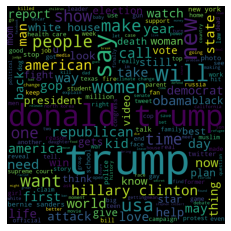

ABC Australia


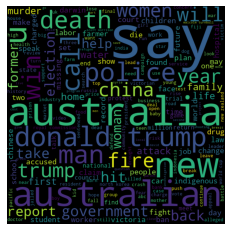

npr


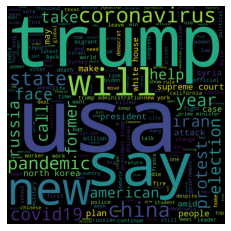

guardian


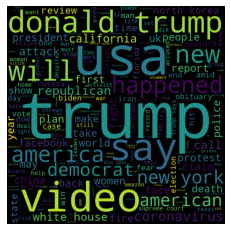

nottheonion


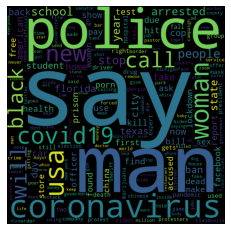

atlantic


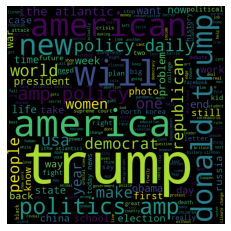

onion


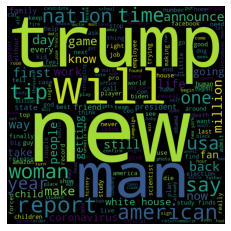

reductress


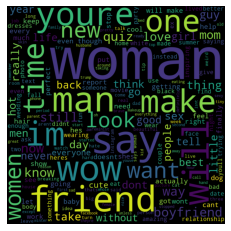

national report


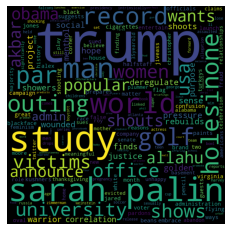

Hard Times


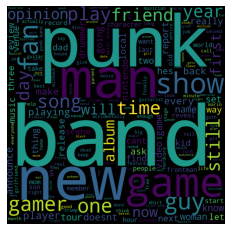

Fox News


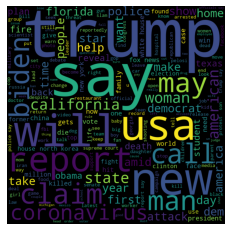

In [29]:
for source in data['source'].unique():
    source_text = data.loc[data['source'] == source]['clean'].astype('U')

    wc = wordcloud.WordCloud(width = 800, height = 800).generate(" ".join(source_text))
    plt.imshow(wc)
    plt.axis("off")
    print(source)
    plt.show()